nodes:  50 links  69


/home/huanghanjun/anaconda3/envs/graph-tool/lib/python3.12/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Generation 0: Min Fitness 4239.936281790018
Generation 1: Min Fitness 4089.7561161996928
Generation 2: Min Fitness 3886.6927381539463
Generation 3: Min Fitness 3886.6927381539463
Generation 4: Min Fitness 3886.6927381539463
Generation 5: Min Fitness 3886.6927381539463
Generation 6: Min Fitness 3722.2405754164693
Generation 7: Min Fitness 3719.9321527584134
Generation 8: Min Fitness 3719.9321527584134
Generation 9: Min Fitness 3719.9321527584134
Generation 10: Min Fitness 3541.4788113689638
Generation 11: Min Fitness 3541.4788113689638
Generation 12: Min Fitness 3453.4701497900933
Generation 13: Min Fitness 3453.4701497900933
Generation 14: Min Fitness 3453.4701497900933
Generation 15: Min Fitness 3417.0486502352887
Generation 16: Min Fitness 3377.695049202688
Generation 17: Min Fitness 3370.804882401394
Generation 18: Min Fitness 3370.804882401394
Generation 19: Min Fitness 3352.9406806535853
Generation 20: Min Fitness 3246.8728390954343
Generation 21: Min Fitness 3246.8728390954343
Ge

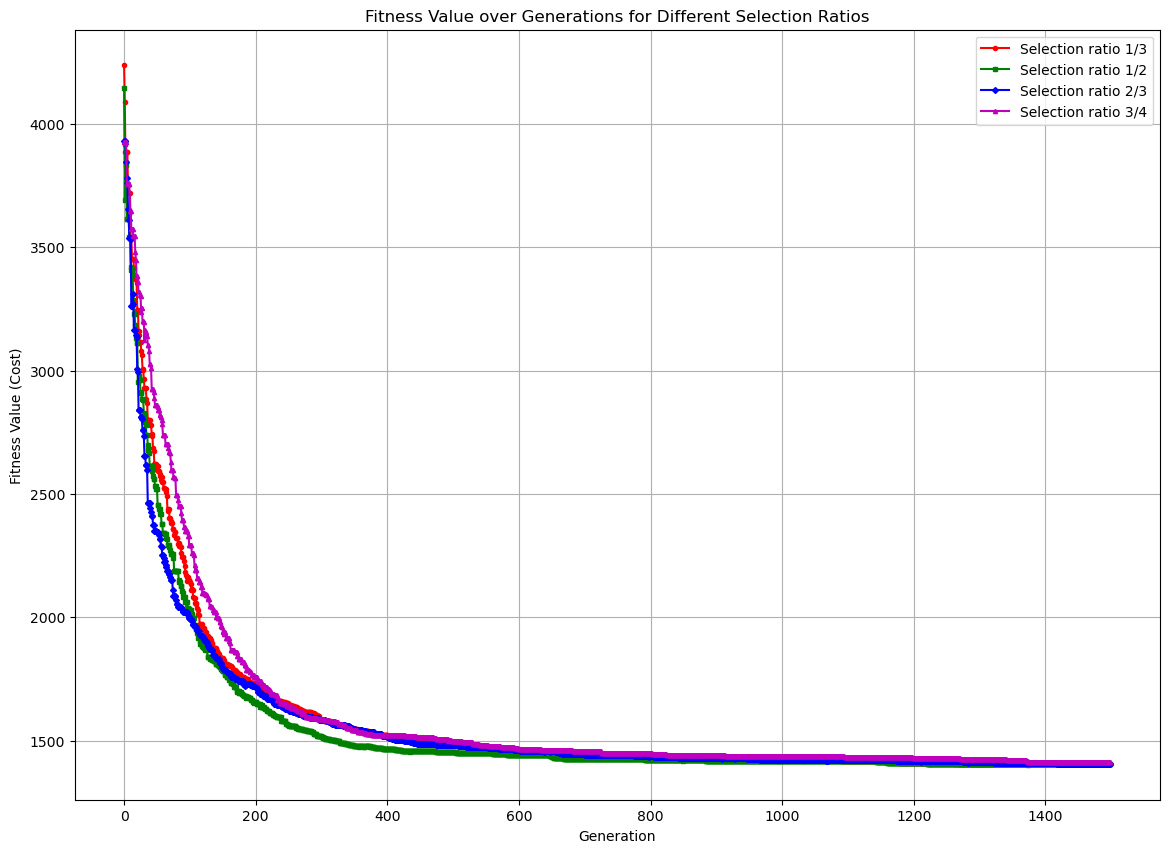

In [3]:
import numpy as np
import random
from graph_tool.all import Graph, shortest_distance, graph_draw
from deap import base, creator, tools, algorithms
import python_codes.files_operators as fo
import matplotlib.pyplot as plt

# 读取图和位置信息　グラフと位置情報を読み取る
filename1 = "Germany50"
read_graph, read_pos = fo.read_files(f"../networks_clusters/{filename1}.net")
num_edges = read_graph.num_edges()
print("nodes: ", read_graph.num_vertices(), "links ", num_edges)

# 计算并添加边的欧氏距离作为权重属性
edge_weights = read_graph.new_edge_property("double")
for edge in read_graph.edges():
    source_pos = read_pos[edge.source()]
    target_pos = read_pos[edge.target()]
    euclidean_distance = np.sqrt((source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
    edge_weights[edge] = euclidean_distance

# 将图转换为个体编码　グラフを個体エンコードに変換する
def graph_to_individual(graph):
    num_vertices = graph.num_vertices()
    individual = [0] * (num_vertices * num_vertices)
    for edge in graph.edges():
        source, target = int(edge.source()), int(edge.target())
        individual[source * num_vertices + target] = 1
        individual[target * num_vertices + source] = 1
    return individual

# 将个体解码为图并计算边权重属性　個体をグラフにデコードし、エッジの重みを計算する
def individual_to_graph(individual, num_vertices):
    graph = Graph(directed=False)
    graph.add_vertex(num_vertices)
    new_edge_weights = graph.new_edge_property("double")
    for i in range(num_vertices):
        for j in range(i + 1, num_vertices):
            if individual[i * num_vertices + j] == 1:
                edge = graph.add_edge(graph.vertex(i), graph.vertex(j))
                source_pos = read_pos[graph.vertex(i)]
                target_pos = read_pos[graph.vertex(j)]
                euclidean_distance = np.sqrt(
                    (source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
                new_edge_weights[edge] = euclidean_distance
    return graph, new_edge_weights

# 定义适应度函数　適応度関数を定義する
def evaluate(individual):
    graph, new_edge_weights = individual_to_graph(individual, read_graph.num_vertices())
    num_edges = graph.num_edges()
    if num_edges != read_graph.num_edges():  # 边数限制，确保边数为文件中边的数量
        return float('inf'),  # 如果边数不为文件中边的数量，适应度设为无穷大
    dist_matrix = shortest_distance(graph, weights=new_edge_weights).get_2d_array(range(graph.num_vertices()))
    total_distance = np.sum(dist_matrix[dist_matrix != np.inf])
    return total_distance,

# 自定义交叉操作　交叉操作
def cxGraph(ind1, ind2):
    size = len(ind1)
    point = random.randint(1, size - 1)
    new_ind1 = creator.Individual(np.concatenate((ind1[:point], ind2[point:])))
    new_ind2 = creator.Individual(np.concatenate((ind2[:point], ind1[point:])))

    # 修正边数
    def fix_edges(individual):
        num_vertices = int(np.sqrt(len(individual)))
        edges = [(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices) if
                 individual[i * num_vertices + j] == 1]
        non_edges = [(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices) if
                     individual[i * num_vertices + j] == 0]
        if len(edges) > num_edges:
            # 移除多余的边
            extra_edges = random.sample(edges, len(edges) - num_edges)
            for i, j in extra_edges:
                individual[i * num_vertices + j] = 0
                individual[j * num_vertices + i] = 0
        elif len(edges) < num_edges:
            # 添加缺失的边
            missing_edges = random.sample(non_edges, num_edges - len(edges))
            for i, j in missing_edges:
                individual[i * num_vertices + j] = 1
                individual[j * num_vertices + i] = 1
        return individual

    new_ind1 = fix_edges(new_ind1)
    new_ind2 = fix_edges(new_ind2)

    return new_ind1, new_ind2

# 自定义变异操作　変異操作
def mutGraph(ind):
    size = int(np.sqrt(len(ind)))
    edges = [(i, j) for i in range(size) for j in range(i + 1, size) if ind[i * size + j] == 1]
    non_edges = [(i, j) for i in range(size) for j in range(i + 1, size) if ind[i * size + j] == 0]

    if edges and non_edges:
        # 移除一条边　エッジを削除する
        i, j = random.choice(edges)
        ind[i * size + j] = 0
        ind[j * size + i] = 0

        # 添加一条边　エッジを追加する
        i, j = random.choice(non_edges)
        ind[i * size + j] = 1
        ind[j * size + i] = 1

    return ind,

# 遗传算法设置　遺伝的アルゴリズムの設定
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)

# 初始化个体时确保边数为文件中的边数量　初期個体を初期化する際にエッジ数をファイル中のエッジ数に確保する
def initIndividual():
    num_vertices = read_graph.num_vertices()
    individual = [0] * (num_vertices * num_vertices)
    edges = random.sample([(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices)], num_edges)
    for i, j in edges:
        individual[i * num_vertices + j] = 1
        individual[j * num_vertices + i] = 1
    return creator.Individual(individual)

toolbox.register("individual", initIndividual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", cxGraph)
toolbox.register("mutate", mutGraph)
toolbox.register("select", tools.selTournament, tournsize=3)

# 主遗传算法流程　メイン遺伝的アルゴリズムフロー
def main(selection_ratio):
    population_size = 300
    num_selected = int(population_size * selection_ratio)
    num_offspring = population_size - num_selected
    num_generations = 1500
    cxpb, mutpb = 0.5, 0.2
    
    # 初始化种群
    pop = toolbox.population(n=population_size)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)

    logbook = tools.Logbook()
    logbook.header = ["gen", "min"]

    for gen in range(num_generations):
        # 选择操作
        selected = toolbox.select(pop, num_selected)
        
        # 生成新的个体
        offspring = algorithms.varAnd(selected, toolbox, cxpb, mutpb)
        offspring = offspring[:num_offspring]
        
        # 组合父代和新生成的个体，形成新的种群
        pop[:] = selected + offspring
        
        # 评估新的种群
        fitnesses = list(map(toolbox.evaluate, pop))
        for ind, fit in zip(pop, fitnesses):
            ind.fitness.values = fit
        
        # 记录和输出每一代的最优适应度值
        record = stats.compile(pop)
        logbook.record(gen=gen, **record)
        print(f"Generation {gen}: Min Fitness {record['min']}")

        # 更新Hall of Fame
        hof.update(pop)

    return logbook, hof

if __name__ == "__main__":
    selection_ratios = [1/3, 1/2, 2/3, 3/4]
    logbooks = []
    hof_list = []

    for ratio in selection_ratios:
        logbook, hof = main(ratio)
        logbooks.append(logbook)
        hof_list.append(hof)

    # 绘制适应度值随迭代次数变化的图表
    plt.figure(figsize=(14, 10))

    markers = ['o', 's', 'D', '^']
    colors = ['r', 'g', 'b', 'm']
    labels = ['1/3', '1/2', '2/3', '3/4']

    for i, logbook in enumerate(logbooks):
        min_fitness_values = logbook.select("min")
        plt.plot(range(len(min_fitness_values)), min_fitness_values, marker=markers[i], linestyle='-', color=colors[i],
                 markerfacecolor=colors[i], markersize=3, label=f'Selection ratio {labels[i]}')

    plt.title("Fitness Value over Generations for Different Selection Ratios")
    plt.xlabel("Generation")
    plt.ylabel("Fitness Value (Cost)")
    plt.legend()
    plt.grid(True)

    # 保存图表
    plt.savefig(f"./output_O/44fitness_over_generations_comparison.png")
    plt.show()


nodes:  50 links  69
Generation 0: Min Fitness 3724.8258826927763
Generation 1: Min Fitness 3649.3804716414325
Generation 2: Min Fitness 3649.3804716414325
Generation 3: Min Fitness 3602.007692660932
Generation 4: Min Fitness 3592.4997464959706
Generation 5: Min Fitness 3547.383501907109
Generation 6: Min Fitness 3561.2249291684975
Generation 7: Min Fitness 3561.2249291684975
Generation 8: Min Fitness 3482.1111638381
Generation 9: Min Fitness 3419.0788541596385
Generation 10: Min Fitness 3419.0788541596385
Generation 11: Min Fitness 3349.1466903679625
Generation 12: Min Fitness 3301.9796331816256
Generation 13: Min Fitness 3349.1466903679625
Generation 14: Min Fitness 3307.5422495626563
Generation 15: Min Fitness 3307.5422495626563
Generation 16: Min Fitness 3276.661849726036
Generation 17: Min Fitness 3221.741830665499
Generation 18: Min Fitness 3221.741830665499
Generation 19: Min Fitness 3219.257897586811
Generation 20: Min Fitness 3134.199824491081
Generation 21: Min Fitness 3134.1

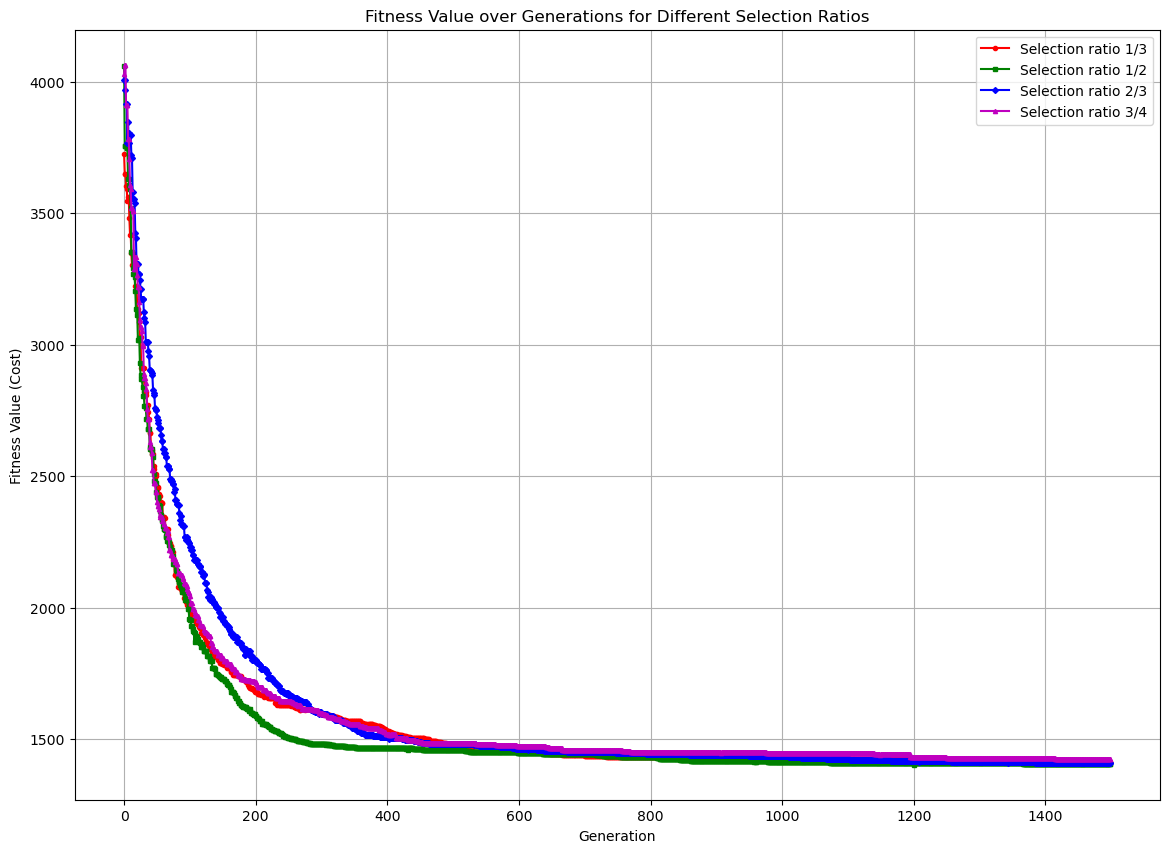

In [4]:
import numpy as np
import random
from graph_tool.all import Graph, shortest_distance, graph_draw
from deap import base, creator, tools, algorithms
import python_codes.files_operators as fo
import matplotlib.pyplot as plt

# 读取图和位置信息　グラフと位置情報を読み取る
filename1 = "Germany50"
read_graph, read_pos = fo.read_files(f"../networks_clusters/{filename1}.net")
num_edges = read_graph.num_edges()
print("nodes: ", read_graph.num_vertices(), "links ", num_edges)

# 计算并添加边的欧氏距离作为权重属性
edge_weights = read_graph.new_edge_property("double")
for edge in read_graph.edges():
    source_pos = read_pos[edge.source()]
    target_pos = read_pos[edge.target()]
    euclidean_distance = np.sqrt((source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
    edge_weights[edge] = euclidean_distance


# 将图转换为个体编码　グラフを個体エンコードに変換する
def graph_to_individual(graph):
    num_vertices = graph.num_vertices()
    individual = [0] * (num_vertices * num_vertices)
    for edge in graph.edges():
        source, target = int(edge.source()), int(edge.target())
        individual[source * num_vertices + target] = 1
        individual[target * num_vertices + source] = 1
    return individual


# 将个体解码为图并计算边权重属性　個体をグラフにデコードし、エッジの重みを計算する
def individual_to_graph(individual, num_vertices):
    graph = Graph(directed=False)
    graph.add_vertex(num_vertices)
    new_edge_weights = graph.new_edge_property("double")
    for i in range(num_vertices):
        for j in range(i + 1, num_vertices):
            if individual[i * num_vertices + j] == 1:
                edge = graph.add_edge(graph.vertex(i), graph.vertex(j))
                source_pos = read_pos[graph.vertex(i)]
                target_pos = read_pos[graph.vertex(j)]
                euclidean_distance = np.sqrt(
                    (source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
                new_edge_weights[edge] = euclidean_distance
    return graph, new_edge_weights


# 定义适应度函数　適応度関数を定義する
def evaluate(individual):
    graph, new_edge_weights = individual_to_graph(individual, read_graph.num_vertices())
    num_edges = graph.num_edges()
    if num_edges != read_graph.num_edges():  # 边数限制，确保边数为文件中边的数量
        return float('inf'),  # 如果边数不为文件中边的数量，适应度设为无穷大
    dist_matrix = shortest_distance(graph, weights=new_edge_weights).get_2d_array(range(graph.num_vertices()))
    total_distance = np.sum(dist_matrix[dist_matrix != np.inf])
    return total_distance,


# 自定义交叉操作　交叉操作
def cxGraph(ind1, ind2):
    size = len(ind1)
    point = random.randint(1, size - 1)
    new_ind1 = creator.Individual(np.concatenate((ind1[:point], ind2[point:])))
    new_ind2 = creator.Individual(np.concatenate((ind2[:point], ind1[point:])))

    # 修正边数
    def fix_edges(individual):
        num_vertices = int(np.sqrt(len(individual)))
        edges = [(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices) if
                 individual[i * num_vertices + j] == 1]
        non_edges = [(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices) if
                     individual[i * num_vertices + j] == 0]
        if len(edges) > num_edges:
            # 移除多余的边
            extra_edges = random.sample(edges, len(edges) - num_edges)
            for i, j in extra_edges:
                individual[i * num_vertices + j] = 0
                individual[j * num_vertices + i] = 0
        elif len(edges) < num_edges:
            # 添加缺失的边
            missing_edges = random.sample(non_edges, num_edges - len(edges))
            for i, j in missing_edges:
                individual[i * num_vertices + j] = 1
                individual[j * num_vertices + i] = 1
        return individual

    new_ind1 = fix_edges(new_ind1)
    new_ind2 = fix_edges(new_ind2)

    return new_ind1, new_ind2


# 自定义变异操作　変異操作
def mutGraph(ind):
    size = int(np.sqrt(len(ind)))
    edges = [(i, j) for i in range(size) for j in range(i + 1, size) if ind[i * size + j] == 1]
    non_edges = [(i, j) for i in range(size) for j in range(i + 1, size) if ind[i * size + j] == 0]

    if edges and non_edges:
        # 移除一条边　エッジを削除する
        i, j = random.choice(edges)
        ind[i * size + j] = 0
        ind[j * size + i] = 0

        # 添加一条边　エッジを追加する
        i, j = random.choice(non_edges)
        ind[i * size + j] = 1
        ind[j * size + i] = 1

    return ind,


# 遗传算法设置　遺伝的アルゴリズムの設定
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)


# 初始化个体时确保边数为文件中的边数量　初期個体を初期化する際にエッジ数をファイル中のエッジ数に確保する
def initIndividual():
    num_vertices = read_graph.num_vertices()
    individual = [0] * (num_vertices * num_vertices)
    edges = random.sample([(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices)], num_edges)
    for i, j in edges:
        individual[i * num_vertices + j] = 1
        individual[j * num_vertices + i] = 1
    return creator.Individual(individual)


toolbox.register("individual", initIndividual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", cxGraph)
toolbox.register("mutate", mutGraph)
toolbox.register("select", tools.selTournament, tournsize=3)


# 主遗传算法流程　メイン遺伝的アルゴリズムフロー
def main(selection_ratio):
    population_size = 300
    num_selected = int(population_size * selection_ratio)
    num_offspring = population_size - num_selected
    num_generations = 1500
    cxpb, mutpb = 0.5, 0.2

    # 初始化种群
    pop = toolbox.population(n=population_size)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)

    logbook = tools.Logbook()
    logbook.header = ["gen", "min"]

    for gen in range(num_generations):
        # 选择操作
        selected = toolbox.select(pop, num_selected)

        # 生成新的个体
        offspring = algorithms.varAnd(selected, toolbox, cxpb, mutpb)
        offspring = offspring[:num_offspring]

        # 组合父代和新生成的个体，形成新的种群
        pop[:] = selected + offspring

        # 评估新的种群
        fitnesses = list(map(toolbox.evaluate, pop))
        for ind, fit in zip(pop, fitnesses):
            ind.fitness.values = fit

        # 记录和输出每一代的最优适应度值
        record = stats.compile(pop)
        logbook.record(gen=gen, **record)
        print(f"Generation {gen}: Min Fitness {record['min']}")

        # 更新Hall of Fame
        hof.update(pop)

    return logbook, hof


if __name__ == "__main__":
    selection_ratios = [1 / 3, 1 / 2, 2 / 3, 3 / 4]
    logbooks = []
    hof_list = []

    for ratio in selection_ratios:
        logbook, hof = main(ratio)
        logbooks.append(logbook)
        hof_list.append(hof)

    # 绘制适应度值随迭代次数变化的图表
    plt.figure(figsize=(14, 10))

    markers = ['o', 's', 'D', '^']
    colors = ['r', 'g', 'b', 'm']
    labels = ['1/3', '1/2', '2/3', '3/4']

    for i, logbook in enumerate(logbooks):
        min_fitness_values = logbook.select("min")
        plt.plot(range(len(min_fitness_values)), min_fitness_values, marker=markers[i], linestyle='-', color=colors[i],
                 markerfacecolor=colors[i], markersize=3, label=f'Selection ratio {labels[i]}')

    plt.title("Fitness Value over Generations for Different Selection Ratios")
    plt.xlabel("Generation")
    plt.ylabel("Fitness Value (Cost)")
    plt.legend()
    plt.grid(True)

    # 保存图表
    plt.savefig(f"./output_O/442fitness_over_generations_comparison.png")
    plt.show()


nodes:  50 links  69
Generation 0: Min Fitness 3830.9791614061305
Generation 1: Min Fitness 3801.269545658146
Generation 2: Min Fitness 3665.3565530698897
Generation 3: Min Fitness 3665.3565530698897
Generation 4: Min Fitness 3515.858930081471
Generation 5: Min Fitness 3409.447647419499
Generation 6: Min Fitness 3285.3686638894587
Generation 7: Min Fitness 3285.3686638894587
Generation 8: Min Fitness 3261.7600085248473
Generation 9: Min Fitness 3211.2105272078925
Generation 10: Min Fitness 3164.5170704037987
Generation 11: Min Fitness 3038.6676778785745
Generation 12: Min Fitness 3038.6676778785745
Generation 13: Min Fitness 3038.6676778785745
Generation 14: Min Fitness 2985.4536469730474
Generation 15: Min Fitness 2870.775211154266
Generation 16: Min Fitness 2870.775211154266
Generation 17: Min Fitness 2747.2888580297513
Generation 18: Min Fitness 2747.2888580297513
Generation 19: Min Fitness 2747.2888580297513
Generation 20: Min Fitness 2743.974828046188
Generation 21: Min Fitness 27

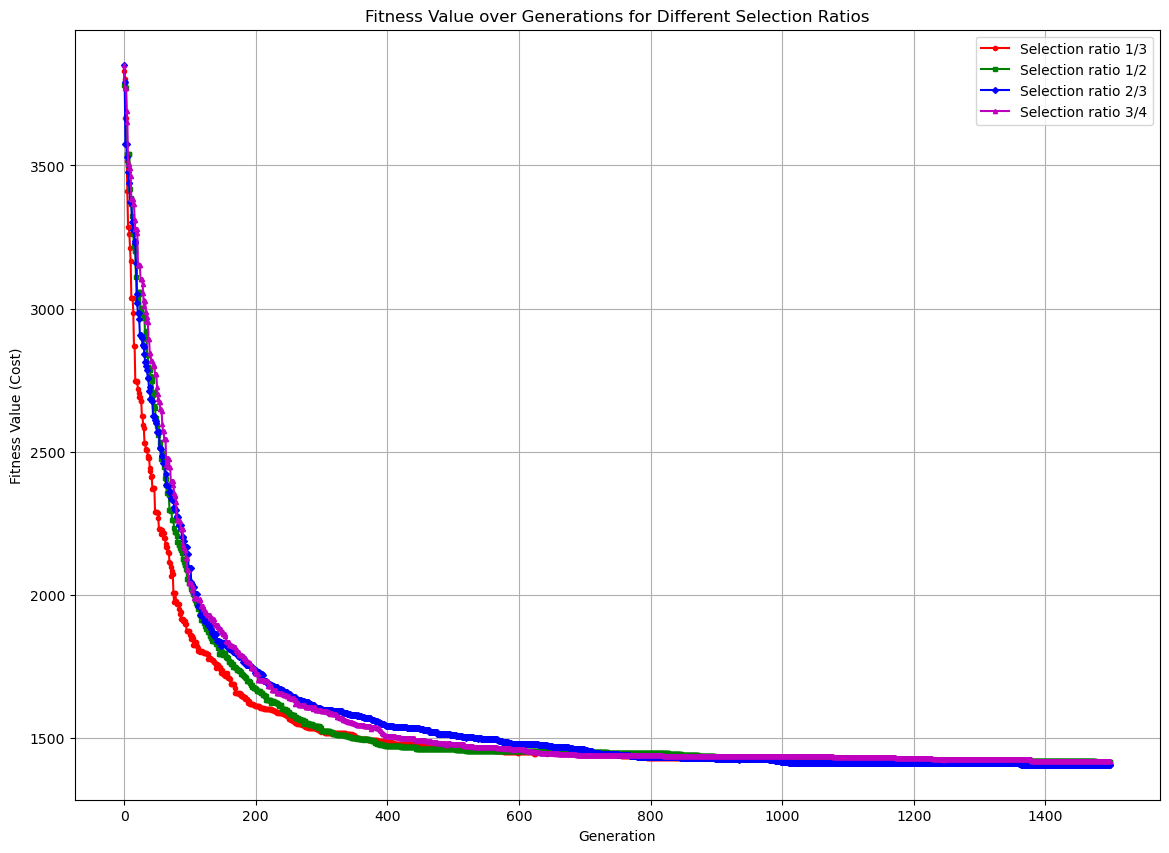

In [5]:
import numpy as np
import random
from graph_tool.all import Graph, shortest_distance, graph_draw
from deap import base, creator, tools, algorithms
import python_codes.files_operators as fo
import matplotlib.pyplot as plt

# 读取图和位置信息　グラフと位置情報を読み取る
filename1 = "Germany50"
read_graph, read_pos = fo.read_files(f"../networks_clusters/{filename1}.net")
num_edges = read_graph.num_edges()
print("nodes: ", read_graph.num_vertices(), "links ", num_edges)

# 计算并添加边的欧氏距离作为权重属性
edge_weights = read_graph.new_edge_property("double")
for edge in read_graph.edges():
    source_pos = read_pos[edge.source()]
    target_pos = read_pos[edge.target()]
    euclidean_distance = np.sqrt((source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
    edge_weights[edge] = euclidean_distance

# 将图转换为个体编码　グラフを個体エンコードに変換する
def graph_to_individual(graph):
    num_vertices = graph.num_vertices()
    individual = [0] * (num_vertices * num_vertices)
    for edge in graph.edges():
        source, target = int(edge.source()), int(edge.target())
        individual[source * num_vertices + target] = 1
        individual[target * num_vertices + source] = 1
    return individual

# 将个体解码为图并计算边权重属性　個体をグラフにデコードし、エッジの重みを計算する
def individual_to_graph(individual, num_vertices):
    graph = Graph(directed=False)
    graph.add_vertex(num_vertices)
    new_edge_weights = graph.new_edge_property("double")
    for i in range(num_vertices):
        for j in range(i + 1, num_vertices):
            if individual[i * num_vertices + j] == 1:
                edge = graph.add_edge(graph.vertex(i), graph.vertex(j))
                source_pos = read_pos[graph.vertex(i)]
                target_pos = read_pos[graph.vertex(j)]
                euclidean_distance = np.sqrt(
                    (source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
                new_edge_weights[edge] = euclidean_distance
    return graph, new_edge_weights

# 定义适应度函数　適応度関数を定義する
def evaluate(individual):
    graph, new_edge_weights = individual_to_graph(individual, read_graph.num_vertices())
    num_edges = graph.num_edges()
    if num_edges != read_graph.num_edges():  # 边数限制，确保边数为文件中边的数量
        return float('inf'),  # 如果边数不为文件中边的数量，适应度设为无穷大
    dist_matrix = shortest_distance(graph, weights=new_edge_weights).get_2d_array(range(graph.num_vertices()))
    total_distance = np.sum(dist_matrix[dist_matrix != np.inf])
    return total_distance,

# 自定义交叉操作　交叉操作
def cxGraph(ind1, ind2):
    size = len(ind1)
    point = random.randint(1, size - 1)
    new_ind1 = creator.Individual(np.concatenate((ind1[:point], ind2[point:])))
    new_ind2 = creator.Individual(np.concatenate((ind2[:point], ind1[point:])))

    # 修正边数
    def fix_edges(individual):
        num_vertices = int(np.sqrt(len(individual)))
        edges = [(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices) if
                 individual[i * num_vertices + j] == 1]
        non_edges = [(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices) if
                     individual[i * num_vertices + j] == 0]
        if len(edges) > num_edges:
            # 移除多余的边
            extra_edges = random.sample(edges, len(edges) - num_edges)
            for i, j in extra_edges:
                individual[i * num_vertices + j] = 0
                individual[j * num_vertices + i] = 0
        elif len(edges) < num_edges:
            # 添加缺失的边
            missing_edges = random.sample(non_edges, num_edges - len(edges))
            for i, j in missing_edges:
                individual[i * num_vertices + j] = 1
                individual[j * num_vertices + i] = 1
        return individual

    new_ind1 = fix_edges(new_ind1)
    new_ind2 = fix_edges(new_ind2)

    return new_ind1, new_ind2

# 自定义变异操作　変異操作
def mutGraph(ind):
    size = int(np.sqrt(len(ind)))
    edges = [(i, j) for i in range(size) for j in range(i + 1, size) if ind[i * size + j] == 1]
    non_edges = [(i, j) for i in range(size) for j in range(i + 1, size) if ind[i * size + j] == 0]

    if edges and non_edges:
        # 移除一条边　エッジを削除する
        i, j = random.choice(edges)
        ind[i * size + j] = 0
        ind[j * size + i] = 0

        # 添加一条边　エッジを追加する
        i, j = random.choice(non_edges)
        ind[i * size + j] = 1
        ind[j * size + i] = 1

    return ind,

# 遗传算法设置　遺伝的アルゴリズムの設定
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)

# 初始化个体时确保边数为文件中的边数量　初期個体を初期化する際にエッジ数をファイル中のエッジ数に確保する
def initIndividual():
    num_vertices = read_graph.num_vertices()
    individual = [0] * (num_vertices * num_vertices)
    edges = random.sample([(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices)], num_edges)
    for i, j in edges:
        individual[i * num_vertices + j] = 1
        individual[j * num_vertices + i] = 1
    return creator.Individual(individual)

toolbox.register("individual", initIndividual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", cxGraph)
toolbox.register("mutate", mutGraph)
toolbox.register("select", tools.selTournament, tournsize=3)

# 主遗传算法流程　メイン遺伝的アルゴリズムフロー
def main(selection_ratio, initial_population):
    population_size = 300
    num_selected = int(population_size * selection_ratio)
    num_offspring = population_size - num_selected
    num_generations = 1500
    cxpb, mutpb = 0.5, 0.2
    
    # 使用相同的初始种群
    pop = initial_population[:]
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)

    logbook = tools.Logbook()
    logbook.header = ["gen", "min"]

    for gen in range(num_generations):
        # 选择操作
        selected = toolbox.select(pop, num_selected)
        
        # 生成新的个体
        offspring = algorithms.varAnd(selected, toolbox, cxpb, mutpb)
        offspring = offspring[:num_offspring]
        
        # 组合父代和新生成的个体，形成新的种群
        pop[:] = selected + offspring
        
        # 评估新的种群
        fitnesses = list(map(toolbox.evaluate, pop))
        for ind, fit in zip(pop, fitnesses):
            ind.fitness.values = fit
        
        # 记录和输出每一代的最优适应度值
        record = stats.compile(pop)
        logbook.record(gen=gen, **record)
        print(f"Generation {gen}: Min Fitness {record['min']}")

        # 更新Hall of Fame
        hof.update(pop)

    return logbook, hof

if __name__ == "__main__":
    selection_ratios = [1/3, 1/2, 2/3, 3/4]
    logbooks = []
    hof_list = []

    # 生成相同的初始种群
    initial_population = toolbox.population(n=300)

    for ratio in selection_ratios:
        logbook, hof = main(ratio, initial_population)
        logbooks.append(logbook)
        hof_list.append(hof)

    # 绘制适应度值随迭代次数变化的图表
    plt.figure(figsize=(14, 10))

    markers = ['o', 's', 'D', '^']
    colors = ['r', 'g', 'b', 'm']
    labels = ['1/3', '1/2', '2/3', '3/4']

    for i, logbook in enumerate(logbooks):
        min_fitness_values = logbook.select("min")
        plt.plot(range(len(min_fitness_values)), min_fitness_values, marker=markers[i], linestyle='-', color=colors[i],
                 markerfacecolor=colors[i], markersize=3, label=f'Selection ratio {labels[i]}')

    plt.title("Fitness Value over Generations for Different Selection Ratios")
    plt.xlabel("Generation")
    plt.ylabel("Fitness Value (Cost)")
    plt.legend()
    plt.grid(True)

    # 保存图表
    plt.savefig(f"./output_O/45fitness_over_generations_comparison.png")
    plt.show()



(ipykernel_launcher.py:2439): Gtk-WARNING **: 17:54:14.028: Locale not supported by C library.
	Using the fallback 'C' locale.


nodes:  50 links  69


/home/huang/anaconda3/envs/gt/lib/python3.12/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Generation 0: Min Fitness 4280.536157497707
Generation 1: Min Fitness 4137.1650462025045
Generation 2: Min Fitness 4188.2076775275855
Generation 3: Min Fitness 4051.4690753086325
Generation 4: Min Fitness 4006.2747076510705
Generation 5: Min Fitness 3967.480089833209
Generation 6: Min Fitness 3539.9139140572343
Generation 7: Min Fitness 3847.1145334406615
Generation 8: Min Fitness 3828.9529253251962
Generation 9: Min Fitness 3686.7652735938755
Generation 10: Min Fitness 3561.9232728794736
Generation 11: Min Fitness 3561.9232728794736
Generation 12: Min Fitness 3402.2639940073077
Generation 13: Min Fitness 3385.348757758882
Generation 14: Min Fitness 3361.725816103477
Generation 15: Min Fitness 3318.9986127732345
Generation 16: Min Fitness 3299.847290825056
Generation 17: Min Fitness 3272.543909877838
Generation 18: Min Fitness 3248.624750424661
Generation 19: Min Fitness 3215.009607625084
Generation 20: Min Fitness 3215.009607625084
Generation 21: Min Fitness 3167.040979829601
Generati

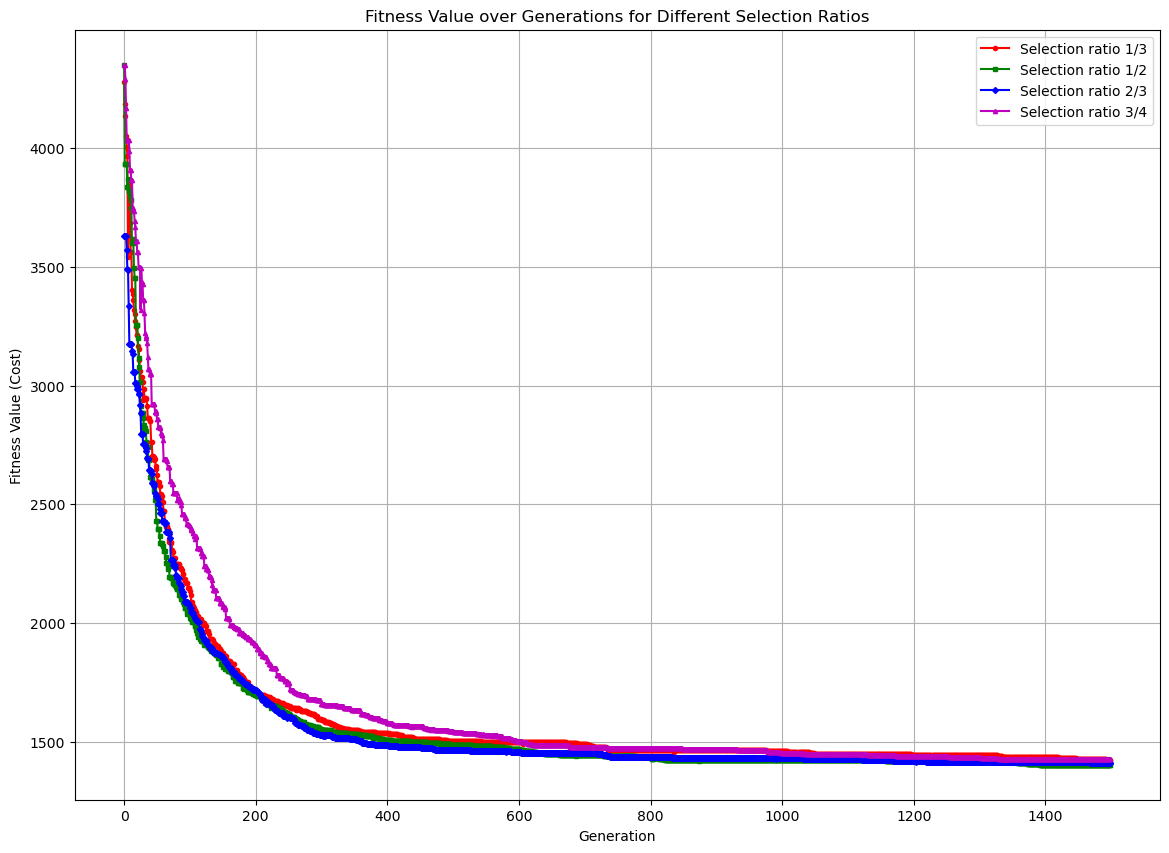

In [1]:
import numpy as np
import random
from graph_tool.all import Graph, shortest_distance, graph_draw
from deap import base, creator, tools, algorithms
import python_codes.files_operators as fo
import matplotlib.pyplot as plt

# 读取图和位置信息　グラフと位置情報を読み取る
filename1 = "Germany50"
read_graph, read_pos = fo.read_files(f"../networks_clusters/{filename1}.net")
num_edges = read_graph.num_edges()
print("nodes: ", read_graph.num_vertices(), "links ", num_edges)

# 计算并添加边的欧氏距离作为权重属性
edge_weights = read_graph.new_edge_property("double")
for edge in read_graph.edges():
    source_pos = read_pos[edge.source()]
    target_pos = read_pos[edge.target()]
    euclidean_distance = np.sqrt((source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
    edge_weights[edge] = euclidean_distance


# 将图转换为个体编码　グラフを個体エンコードに変換する
def graph_to_individual(graph):
    num_vertices = graph.num_vertices()
    individual = [0] * (num_vertices * num_vertices)
    for edge in graph.edges():
        source, target = int(edge.source()), int(edge.target())
        individual[source * num_vertices + target] = 1
        individual[target * num_vertices + source] = 1
    return individual


# 将个体解码为图并计算边权重属性　個体をグラフにデコードし、エッジの重みを計算する
def individual_to_graph(individual, num_vertices):
    graph = Graph(directed=False)
    graph.add_vertex(num_vertices)
    new_edge_weights = graph.new_edge_property("double")
    for i in range(num_vertices):
        for j in range(i + 1, num_vertices):
            if individual[i * num_vertices + j] == 1:
                edge = graph.add_edge(graph.vertex(i), graph.vertex(j))
                source_pos = read_pos[graph.vertex(i)]
                target_pos = read_pos[graph.vertex(j)]
                euclidean_distance = np.sqrt(
                    (source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
                new_edge_weights[edge] = euclidean_distance
    return graph, new_edge_weights


# 定义适应度函数　適応度関数を定義する
def evaluate(individual):
    graph, new_edge_weights = individual_to_graph(individual, read_graph.num_vertices())
    num_edges = graph.num_edges()
    if num_edges != read_graph.num_edges():  # 边数限制，确保边数为文件中边的数量
        return float('inf'),  # 如果边数不为文件中边的数量，适应度设为无穷大
    dist_matrix = shortest_distance(graph, weights=new_edge_weights).get_2d_array(range(graph.num_vertices()))
    total_distance = np.sum(dist_matrix[dist_matrix != np.inf])
    return total_distance,


# 自定义交叉操作　交叉操作
def cxGraph(ind1, ind2):
    size = len(ind1)
    point = random.randint(1, size - 1)
    new_ind1 = creator.Individual(np.concatenate((ind1[:point], ind2[point:])))
    new_ind2 = creator.Individual(np.concatenate((ind2[:point], ind1[point:])))

    # 修正边数
    def fix_edges(individual):
        num_vertices = int(np.sqrt(len(individual)))
        edges = [(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices) if
                 individual[i * num_vertices + j] == 1]
        non_edges = [(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices) if
                     individual[i * num_vertices + j] == 0]
        if len(edges) > num_edges:
            # 移除多余的边
            extra_edges = random.sample(edges, len(edges) - num_edges)
            for i, j in extra_edges:
                individual[i * num_vertices + j] = 0
                individual[j * num_vertices + i] = 0
        elif len(edges) < num_edges:
            # 添加缺失的边
            missing_edges = random.sample(non_edges, num_edges - len(edges))
            for i, j in missing_edges:
                individual[i * num_vertices + j] = 1
                individual[j * num_vertices + i] = 1
        return individual

    new_ind1 = fix_edges(new_ind1)
    new_ind2 = fix_edges(new_ind2)

    return new_ind1, new_ind2


# 自定义变异操作　変異操作
def mutGraph(ind):
    size = int(np.sqrt(len(ind)))
    edges = [(i, j) for i in range(size) for j in range(i + 1, size) if ind[i * size + j] == 1]
    non_edges = [(i, j) for i in range(size) for j in range(i + 1, size) if ind[i * size + j] == 0]

    if edges and non_edges:
        # 移除一条边　エッジを削除する
        i, j = random.choice(edges)
        ind[i * size + j] = 0
        ind[j * size + i] = 0

        # 添加一条边　エッジを追加する
        i, j = random.choice(non_edges)
        ind[i * size + j] = 1
        ind[j * size + i] = 1

    return ind,


# 遗传算法设置　遺伝的アルゴリズムの設定
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)


# 初始化个体时确保边数为文件中的边数量　初期個体を初期化する際にエッジ数をファイル中のエッジ数に確保する
def initIndividual():
    num_vertices = read_graph.num_vertices()
    individual = [0] * (num_vertices * num_vertices)
    edges = random.sample([(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices)], num_edges)
    for i, j in edges:
        individual[i * num_vertices + j] = 1
        individual[j * num_vertices + i] = 1
    return creator.Individual(individual)


toolbox.register("individual", initIndividual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", cxGraph)
toolbox.register("mutate", mutGraph)
toolbox.register("select", tools.selTournament, tournsize=3)


# 主遗传算法流程　メイン遺伝的アルゴリズムフロー
def main(selection_ratio, initial_population):
    population_size = 300
    num_selected = int(population_size * selection_ratio)
    num_offspring = population_size - num_selected
    num_generations = 1500
    cxpb, mutpb = 0.5, 0.2

    # 使用相同的初始种群
    pop = initial_population[:]
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)

    logbook = tools.Logbook()
    logbook.header = ["gen", "min"]

    for gen in range(num_generations):
        # 选择操作
        selected = toolbox.select(pop, num_selected)

        # 生成新的个体
        offspring = algorithms.varAnd(selected, toolbox, cxpb, mutpb)
        offspring = offspring[:num_offspring]

        # 组合父代和新生成的个体，形成新的种群
        pop[:] = selected + offspring

        # 评估新的种群
        fitnesses = list(map(toolbox.evaluate, pop))
        for ind, fit in zip(pop, fitnesses):
            ind.fitness.values = fit

        # 记录和输出每一代的最优适应度值
        record = stats.compile(pop)
        logbook.record(gen=gen, **record)
        print(f"Generation {gen}: Min Fitness {record['min']}")

        # 更新Hall of Fame
        hof.update(pop)

    return logbook, hof


if __name__ == "__main__":
    selection_ratios = [1 / 3, 1 / 2, 2 / 3, 3 / 4]
    logbooks = []
    hof_list = []

    # 生成相同的初始种群
    initial_population = toolbox.population(n=300)

    for ratio in selection_ratios:
        logbook, hof = main(ratio, initial_population)
        logbooks.append(logbook)
        hof_list.append(hof)

    # 绘制适应度值随迭代次数变化的图表
    plt.figure(figsize=(14, 10))

    markers = ['o', 's', 'D', '^']
    colors = ['r', 'g', 'b', 'm']
    labels = ['1/3', '1/2', '2/3', '3/4']

    for i, logbook in enumerate(logbooks):
        min_fitness_values = logbook.select("min")
        plt.plot(range(len(min_fitness_values)), min_fitness_values, marker=markers[i], linestyle='-', color=colors[i],
                 markerfacecolor=colors[i], markersize=3, label=f'Selection ratio {labels[i]}')

    plt.title("Fitness Value over Generations for Different Selection Ratios")
    plt.xlabel("Generation")
    plt.ylabel("Fitness Value (Cost)")
    plt.legend()
    plt.grid(True)

    # 保存图表
    plt.savefig(f"./output_O/455fitness_over_generations_comparison.png")
    plt.show()
